In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from datetime import timedelta
from datetime import datetime as dt
from utils import get_indiv_fomc, plot_indiv_fomc, get_cs_avg_new, plot_cs_avg, get_panel_bucket
os.chdir("C:/Users/zheng/Documents/Finance Research/")
plt.style.use('ggplot')
palette = sns.color_palette("husl", 3)

## Loading

In [18]:
os.chdir("C:/Users/zheng/Documents/Finance Research/")
event_df = pd.read_csv("Data/macro/data/macro/macro_announcement_dates_202112.csv")
for col in event_df.columns:
    event_df[col] = pd.to_datetime(event_df[col], format="%m/%d/%Y")
# event_df.head()

- Note 11/11 : For FOMC on 2019-12-19, vix futures data on 24th is incomplete because of christimas eve.

In [3]:
fomc_pc = pd.read_excel('Data/macro/data/macro/fomc_scheduled_date_time_2.xlsx')
fomc_pc['Datetime'] = pd.to_datetime(fomc_pc['OfficialTime'], format="%Y-%m-d %H:%M:%S.%f")
# fomc_pc['Datetime'] =  fomc_pc['Datetime'].apply(lambda t: t.replace(hour=14,minute=0,second=0))
fomc_pc.drop('OfficialTime', axis=1, inplace=True)
fomc_pc.set_index('Datetime', inplace=True)
fomc_pc.head()

,PC
Datetime,
1997-09-30 14:15:00,0
1997-11-12 14:15:00,0
1997-12-16 14:15:00,0
1998-02-04 14:15:00,0
1998-03-31 14:15:00,0


In [4]:
fomc_pc = pd.concat([fomc_pc.iloc[119:170], fomc_pc.iloc[171:190]]) # Omitting 2019-12-19
fomc_pc.head()

,PC
Datetime,
2012-08-01 14:15:00,0
2012-09-13 12:30:00,1
2012-10-24 14:15:00,0
2012-12-12 12:30:00,1
2013-01-30 14:15:00,0


In [5]:
fomc_pc_1218 = fomc_pc.loc['2012-01-01 14:00:00': '2019-01-01 14:00:00']
fomc_pc_1218T = fomc_pc_1218[fomc_pc_1218['PC'] == 1]
fomc_pc_1218F = fomc_pc_1218[fomc_pc_1218['PC'] == 0]
fomc_pc_1218.head()

,PC
Datetime,
2012-08-01 14:15:00,0
2012-09-13 12:30:00,1
2012-10-24 14:15:00,0
2012-12-12 12:30:00,1
2013-01-30 14:15:00,0


In [7]:
vix_index = pd.read_csv("Data/vix_futures/data/vix_futures/IAP/IAP.csv")
vix_index["Datetime"] = pd.to_datetime(vix_index["Date"] + " " + vix_index["Time"], format="%m/%d/%Y %H:%M:%S.%f")
vix_index["Datetime"] = vix_index["Datetime"] + timedelta(hours=1) # Adjust time to ET
vix_index.set_index('Datetime', inplace=True)
vix_index.drop(['Date', 'Time'], axis = 1, inplace=True)
vix_index = vix_index.between_time('9:30', '16:02') # To adjust for data error
vix_index.head()

,Price
Datetime,
2003-07-01 09:45:05,22.47
2003-07-01 09:46:05,22.46
2003-07-01 09:47:05,22.20
2003-07-01 09:48:05,22.44
2003-07-01 09:49:05,22.34


In [9]:
spx_30min = pd.read_csv("Data/spy_ohlc_30min.csv")
spx_30min["Datetime"] = pd.to_datetime(spx_30min["Date"], format="%Y-%m-%d %H:%M")
spx_30min.set_index('Datetime', inplace=True)
spx_30min.drop(['Date', 'High', 'Low'], axis = 1, inplace=True)
spx_30min.sort_index(inplace=True)
spx_30min.head()

,Open,Close
Datetime,,
2008-01-02 09:30:00,1467.97,1469.37
2008-01-02 10:00:00,1467.11,1459.91
2008-01-02 10:30:00,1459.76,1456.92
2008-01-02 11:00:00,1457.00,1453.48
2008-01-02 11:30:00,1453.39,1452.49


In [19]:
spy_1min = pd.read_parquet('Data/spy_hyg_lqd_tlt_shy_1min_ret.parquet').rename(columns= {'datetime': 'Datetime'})
spy_1min = spy_1min[spy_1min['symbol'] == 'SPY'].reset_index(drop=True).set_index('Datetime')
spy_1min.head()

,symbol,midquote,bid,ask,ret
Datetime,,,,,
2007-01-03 09:31:00,SPY,142.025,142.02,142.03,-0.001617
2007-01-03 09:32:00,SPY,142.155,142.15,142.16,0.000915
2007-01-03 09:33:00,SPY,142.195,142.19,142.20,0.000281
2007-01-03 09:34:00,SPY,142.255,142.25,142.26,0.000422
2007-01-03 09:35:00,SPY,142.175,142.17,142.18,-0.000562


## Cumilative changes, log returns and cross sectional averages

### 2012 to 2018 All FOMC

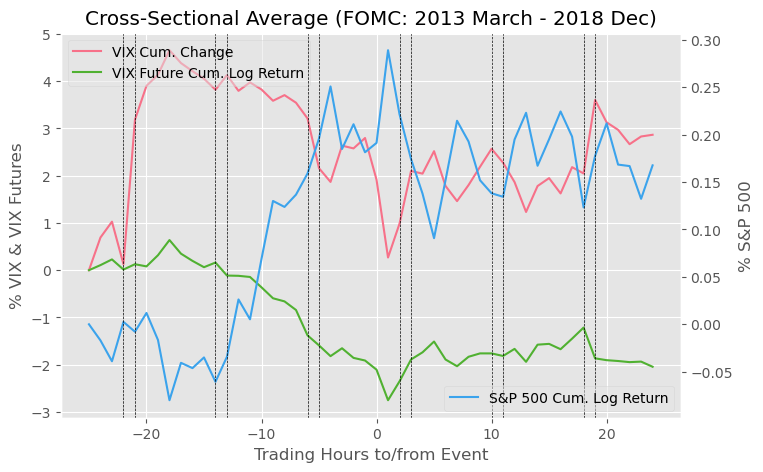

In [42]:
cs_avg_1218 = get_cs_avg_new(vix_index, spx_30min, list(fomc_pc_1218.index), fomc_pc, 1, 24, 'h')
plot_cs_avg(cs_avg_1218[1], 'Cross-Sectional Average (FOMC: 2013 March - 2018 Dec)')


In [44]:
cs_avg_1218[0][1]

Symbol           Open Time  \
Event Datetime      Datetime                                         
2013-03-20 14:00:00 2013-03-15 13:00:00  VXJ13  12:55:01.838000000   
                    2013-03-15 14:00:00  VXJ13  13:55:00.791000000   
                    2013-03-15 15:00:00  VXJ13  14:55:02.035000000   
                    2013-03-15 16:00:00  VXJ13  15:55:00.026000000   
                    2013-03-18 09:00:00  VXJ13  09:25:08.426000000   
...                                        ...                 ...   
2018-11-08 14:00:00 2018-11-13 10:00:00  VXZ18  09:55:00.063000000   
                    2018-11-13 11:00:00  VXZ18  10:55:00.012000000   
                    2018-11-13 12:00:00  VXZ18  11:55:00.804000000   
                    2018-11-13 13:00:00  VXZ18  12:55:00.057000000   
                    2018-11-13 14:00:00  VXZ18  13:55:00.232000000   

                                                 Close Time   Price  \
Event Datetime      Datetime                                          
2013-03-20 14:00:00 2013-03-15 13:00:00  12:59:54.591000000  14.625   
                    2013-03-15 14:00:00  13:59:58.927000000  14.675   
                    2013-03-15 15:00:00  14:59:55.295000000  14.775   
                    2013-03-15 16:00:00  15:59:59.983000000  14.575   
                    2013-03-18 09:00:00  09:29:59.965000000  15.475   
...                                                     ...     ...   
2018-11-08 14:00:00 2018-11-13 10:00:00  09:59:59.983000000  18.925   
                    2018-11-13 11:00:00  10:59:59.797000000  18.925   
                    2018-11-13 12:00:00  11:59:59.509000000  18.725   
                    2018-11-13 13:00:00  12:59:59.506000000  18.975   
                    2018-11-13 14:00:00  13:59:59.481000000  18.925   

                                         Datetime Label  Log Price  \
Event Datetime      Datetime                                         
2013-03-20 14:00:00 2013-03-15 13:00:00             -25   2.682732   
                    2013-03-15 14:00:00             -24   2.686145   
                    2013-03-15 15:00:00             -23   2.692937   
                    2013-03-15 16:00:00             -22   2.679308   
                    2013-03-18 09:00:00             -21   2.739226   
...                                                 ...        ...   
2018-11-08 14:00:00 2018-11-13 10:00:00              20   2.940484   
                    2018-11-13 11:00:00              21   2.940484   
                    2018-11-13 12:00:00              22   2.929860   
                    2018-11-13 13:00:00              23   2.943122   
                    2018-11-13 14:00:00              24   2.940484   

                                         Log Return %  Cum. Log Return %  
Event Datetime      Datetime                                              
2013-03-20 14:00:00 2013-03-15 13:00:00      0.000000           0.000000  
                    2013-03-15 14:00:00      0.341297           0.341297  
                    2013-03-15 15:00:00      0.679120           1.020417  
                    2013-03-15 16:00:00     -1.362883          -0.342466  
                    2013-03-18 09:00:00      5.991809           5.649343  
...                                               ...                ...  
2018-11-08 14:00:00 2018-11-13 10:00:00      0.795760          -0.789478  
                    2018-11-13 11:00:00      0.000000          -0.789478  
                    2018-11-13 12:00:00     -1.062427          -1.851905  
                    2018-11-13 13:00:00      1.326279          -0.525625  
                    2018-11-13 14:00:00     -0.263852          -0.789478  

[2300 rows x 8 columns]

In [35]:
test = pd.merge(cs_avg_1218[0][0], cs_avg_1218[0][1], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

,,Price_x,Datetime Label_x,% Change,Cum. % Change,PC,Symbol,Open Time,Close Time,Price_y,Datetime Label_y,Log Price,Log Return %,Cum. Log Return %
Event Datetime,Datetime,,,,,,,,,,,,,


In [36]:
test = pd.merge(cs_avg_1218[0][1], cs_avg_1218[0][2], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

,,Symbol,Open Time,Close Time,Price_x,Datetime Label_x,Log Price_x,Log Return %_x,Cum. Log Return %_x,Open,Close,Datetime Label_y,Price_y,Log Price_y,Log Return %_y,Cum. Log Return %_y
Event Datetime,Datetime,,,,,,,,,,,,,,,


### 2012 - 2018 FOMC with PC

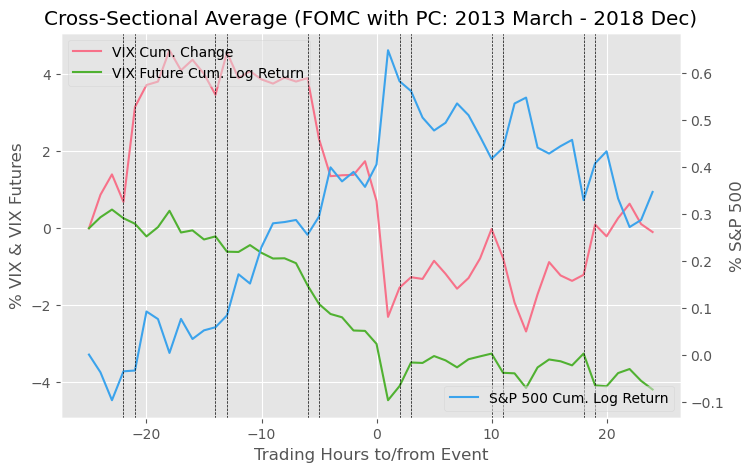

In [26]:
cs_avg_1218_pc = get_cs_avg_new(vix_index, spx_30min, list(fomc_pc_1218T.index), fomc_pc, 1, 24, 'h')
plot_cs_avg(cs_avg_1218_pc[1], 'Cross-Sectional Average (FOMC with PC: 2013 March - 2018 Dec)')

In [27]:
test = pd.merge(cs_avg_1218_pc[0][0], cs_avg_1218_pc[0][1], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

,,Price_x,Datetime Label_x,% Change,Cum. % Change,PC,Symbol,Open Time,Close Time,Price_y,Datetime Label_y,Log Price,Log Return %,Cum. Log Return %
Event Datetime,Datetime,,,,,,,,,,,,,


In [28]:
test = pd.merge(cs_avg_1218_pc[0][1], cs_avg_1218_pc[0][2], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

,,Symbol,Open Time,Close Time,Price_x,Datetime Label_x,Log Price_x,Log Return %_x,Cum. Log Return %_x,Open,Close,Datetime Label_y,Price_y,Log Price_y,Log Return %_y,Cum. Log Return %_y
Event Datetime,Datetime,,,,,,,,,,,,,,,


### 2012 - 2018 FOMC without PC

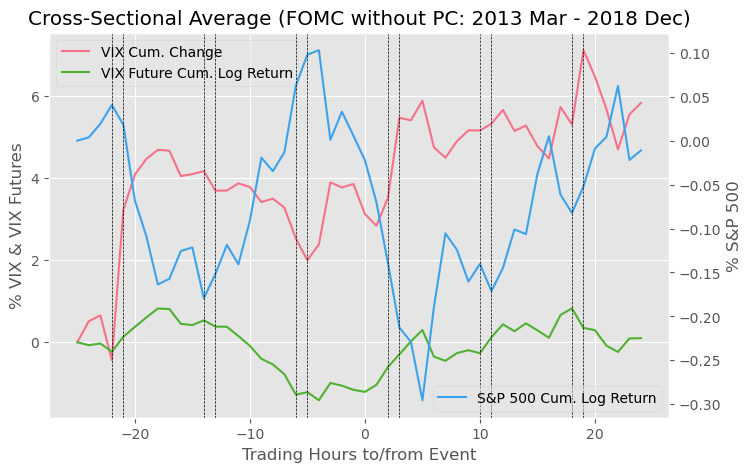

In [29]:
cs_avg_1218_nopc = get_cs_avg_new(vix_index, spx_30min, list(fomc_pc_1218F.index), fomc_pc, 1, 24, 'h')
plot_cs_avg(cs_avg_1218_nopc[1], 'Cross-Sectional Average (FOMC without PC: 2013 Mar - 2018 Dec)')

In [30]:
test = pd.merge(cs_avg_1218_nopc[0][0], cs_avg_1218_nopc[0][1], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

,,Price_x,Datetime Label_x,% Change,Cum. % Change,PC,Symbol,Open Time,Close Time,Price_y,Datetime Label_y,Log Price,Log Return %,Cum. Log Return %
Event Datetime,Datetime,,,,,,,,,,,,,


In [31]:
test = pd.merge(cs_avg_1218_nopc[0][1], cs_avg_1218_nopc[0][2], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

,,Symbol,Open Time,Close Time,Price_x,Datetime Label_x,Log Price_x,Log Return %_x,Cum. Log Return %_x,Open,Close,Datetime Label_y,Price_y,Log Price_y,Log Return %_y,Cum. Log Return %_y
Event Datetime,Datetime,,,,,,,,,,,,,,,


### 2012 - 2021 all FOMC

In [17]:
cs_avg_full = get_cs_avg_new(vix_index, spy_1min, list(fomc_pc.index), fomc_pc, 1, 58, 10, '5min')
# plot_cs_avg(cs_avg_full[1], 'Cross-Sectional Average (FOMC: 2013 Mar - 2021 June)')

KeyError: 'Open'

In [16]:
test = pd.merge(cs_avg_full[0][0], cs_avg_full[0][1], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

Price_x  Datetime Label_x  % Change  \
Event Datetime      Datetime                                                   
2015-07-29 14:00:00 2015-07-28 15:35:00    13.54             -59.0       0.0   
                    2015-07-28 16:00:00      NaN               NaN       NaN   
2016-03-16 14:00:00 2016-03-15 15:35:00    17.15             -59.0       0.0   
                    2016-03-16 09:30:00      NaN               NaN       NaN   

                                         Cum. % Change   PC Symbol  \
Event Datetime      Datetime                                         
2015-07-29 14:00:00 2015-07-28 15:35:00            0.0  0.0    NaN   
                    2015-07-28 16:00:00            NaN  NaN  VXQ15   
2016-03-16 14:00:00 2016-03-15 15:35:00            0.0  1.0    NaN   
                    2016-03-16 09:30:00            NaN  NaN  VXJ16   

                                                  Open Time  \
Event Datetime      Datetime                                  
2015-07-29 14:00:00 2015-07-28 15:35:00                 NaN   
                    2015-07-28 16:00:00  15:55:00.418000000   
2016-03-16 14:00:00 2016-03-15 15:35:00                 NaN   
                    2016-03-16 09:30:00  09:25:00.326000000   

                                                 Close Time  Price_y  \
Event Datetime      Datetime                                           
2015-07-29 14:00:00 2015-07-28 15:35:00                 NaN      NaN   
                    2015-07-28 16:00:00  15:59:59.876000000   14.475   
2016-03-16 14:00:00 2016-03-15 15:35:00                 NaN      NaN   
                    2016-03-16 09:30:00  09:29:59.071000000   19.325   

                                         Datetime Label_y  Log Price  \
Event Datetime      Datetime                                           
2015-07-29 14:00:00 2015-07-28 15:35:00               NaN        NaN   
                    2015-07-28 16:00:00             -55.0   2.672423   
2016-03-16 14:00:00 2016-03-15 15:35:00               NaN        NaN   
                    2016-03-16 09:30:00             -54.0   2.961400   

                                         Log Return %  Cum. Log Return %  
Event Datetime      Datetime                                              
2015-07-29 14:00:00 2015-07-28 15:35:00           NaN                NaN  
                    2015-07-28 16:00:00      0.346021           0.693244  
2016-03-16 14:00:00 2016-03-15 15:35:00           NaN                NaN  
                    2016-03-16 09:30:00      1.564569           1.040321

In [34]:
test = pd.merge(cs_avg_full[0][1], cs_avg_full[0][2], how='outer', left_index=True, right_index=True)
test[~test.index.isin(test.dropna().index)]

,,Symbol,Open Time,Close Time,Price_x,Datetime Label_x,Log Price_x,Log Return %_x,Cum. Log Return %_x,Open,Close,Datetime Label_y,Price_y,Log Price_y,Log Return %_y,Cum. Log Return %_y
Event Datetime,Datetime,,,,,,,,,,,,,,,


## Individual FOMC

### All

In [ ]:
indiv_fomc_all = get_indiv_fomc(fomc_datetimes[148:], vix_index, spx_30min, 24, 'h', 1)

In [ ]:
plot_indiv_fomc(indiv_fomc_all)

### Previous day fed watch odds > 0.25

In [ ]:
effr = pd.read_csv('Data/effr.csv')
effr['Effective Date'] = pd.to_datetime(effr['Effective Date'], format="%m/%d/%Y")
fwprob = pd.read_csv("Data/fw_prob.csv")
fwprob.drop('Unnamed: 0', axis=1, inplace=True)
fwprob['WatchDate'] = pd.to_datetime(fwprob['WatchDate'], format="%Y-%m-%d")
effr_fwprob = effr.merge(fwprob, how='left', left_on = 'Effective Date', right_on = 'WatchDate')
effr_fwprob = effr_fwprob.dropna(axis=1, how='all')
effr_fwprob = pd.concat([effr_fwprob[['Effective Date', 'Rate (%)', 'Target Rate From (%)', 'Target Rate To (%)']],
                  effr_fwprob.iloc[:, 15:]], axis=1)
effr_fwprob.set_index('Effective Date', inplace=True)
fomc_index = [effr_fwprob.index.get_loc(x.replace(hour=0)) for x in fomc_datetimes[148:]]
filt_rows = [effr_fwprob.iloc[x+1:x+2, :].reset_index() for x in fomc_index]
effr_fwprob_prefomc = pd.concat(filt_rows, axis=0)
effr_fwprob_prefomc['Uncertain'] = (effr_fwprob_prefomc.iloc[:, 6:] > 0.2).sum(axis=1) >= 2
effr_fwprob_prefomc = effr_fwprob_prefomc[effr_fwprob_prefomc['Uncertain'] == True]
uncertain_fomc = pd.to_datetime(effr_fwprob_prefomc['FOMCDate'], format="%Y-%m-%d") + pd.Timedelta(hours=14)
uncertain_fomc = [x for x in uncertain_fomc]
uncertain_fomc

In [10]:
indiv_fomc_effr = get_indiv_fomc(uncertain_fomc, vix_index, spx_30min, 24, 'h', 1)

In [ ]:
plot_indiv_fomc(indiv_fomc_effr)

### Absolute difference between Cum.Change VIX Cum. Log Return VIX Futures 

In [17]:
fomc_10diff = []
for fomc in indiv_fomc_all:
    diff = abs(fomc[0]['Cum. % Change'].iloc[-1] - fomc[1]['Cum. Log Return %'].iloc[-1])
    if diff > 10:
        fomc_10diff.append(fomc[0].index[0][0])
indiv_fomc_10diff = get_indiv_fomc(fomc_10diff, vix_index, spx_30min, 24, 'h', 1 )

In [ ]:
plot_indiv_fomc(indiv_fomc_10diff)

## Regression (2012 - 2021)

- Intraday: -25 to -22, -21 to -14, -13 to -6, -5 to 0
- Heightned uncertainty pre announcement period: -6 to 0 
- BGM pre announcement period: -13 to 0 

In [27]:
panel_t1 = get_panel_bucket(cs_avg_full[0], -24, -14)
panel_t2 = get_panel_bucket(cs_avg_full[0], -13, 0)
panel_t3 = get_panel_bucket(cs_avg_full[0], -6, 0)

In [70]:
panel_o1 = get_panel_bucket(cs_avg_full[0], -22, -21)
panel_o2 = get_panel_bucket(cs_avg_full[0], -14, -13)
panel_o3 = get_panel_bucket(cs_avg_full[0], -6, -5)

In [75]:
t1_POLS = PanelOLS.from_formula("Cum_Log_Return_SP500 ~ 1 + Cum_Log_Return_VIX_Fut*PC + Cum_Change_VIX*PC", panel_t1[0]).fit(cov_type='clustered', clusters=panel_t1[1])
print(t1_POLS)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Cum_Log_Return_SP500   R-squared:                        0.6525
Estimator:                     PanelOLS   R-squared (Between):              0.7002
No. Observations:                   770   R-squared (Within):               0.5285
Date:                  Fri, Nov 01 2024   R-squared (Overall):              0.6525
Time:                          15:46:10   Log-likelihood                   -320.44
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      286.87
Entities:                            70   P-value                           0.0000
Avg Obs:                         11.000   Distribution:                   F(5,764)
Min Obs:                         11.000                                           
Max Obs:                         11.000   F-statistic (robust):             28.959
    

In [76]:
resid_t1 = t1_POLS.resids.reset_index().join(fomc_pc, how='left', on='Event Datetime')
resid_t1

,Event Datetime,Datetime Label,residual,PC
0,2012-08-01 14:00:00,-24,0.455925,0
1,2012-08-01 14:00:00,-23,0.421628,0
2,2012-08-01 14:00:00,-22,0.542918,0
3,2012-08-01 14:00:00,-21,0.580624,0
4,2012-08-01 14:00:00,-20,0.598912,0
...,...,...,...,...
765,2021-06-16 14:00:00,-18,0.133182,1
766,2021-06-16 14:00:00,-17,0.244229,1
767,2021-06-16 14:00:00,-16,0.233540,1
768,2021-06-16 14:00:00,-15,0.296484,1


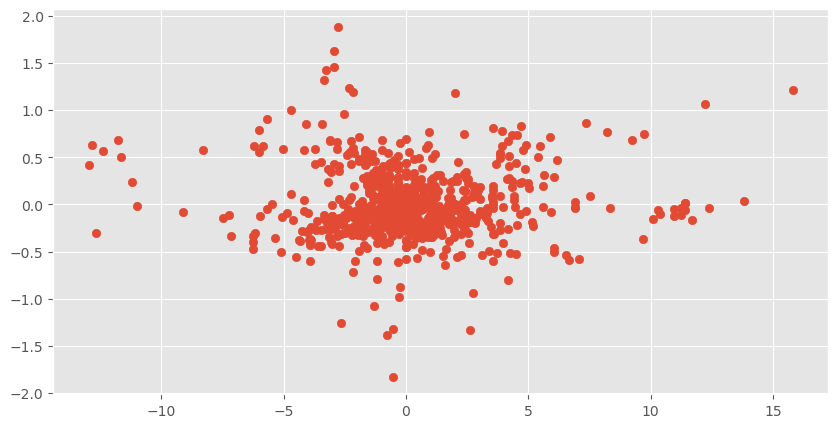

In [77]:
fig, axs = plt.subplots(figsize=(10,5))
axs.scatter(panel_t1[0]['Cum_Log_Return_VIX_Fut'], resid_t1['residual'])

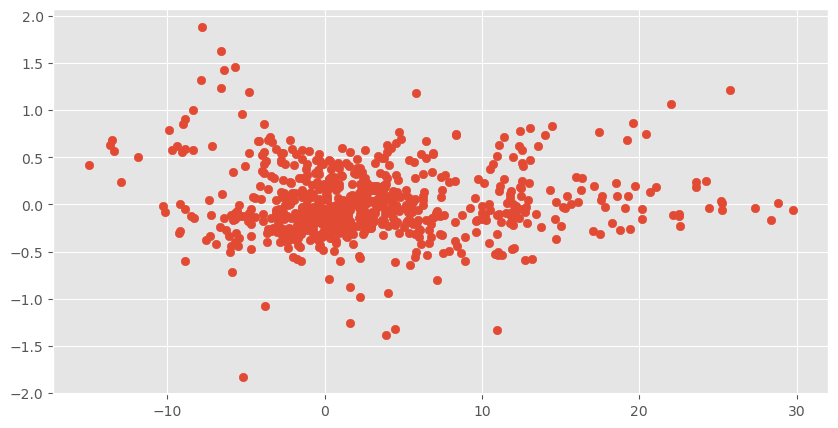

In [78]:
fig, axs = plt.subplots(figsize=(10,5))
axs.scatter(panel_t1[0]['Cum_Change_VIX'], resid_t1['residual'])

In [28]:
t2_POLS = PanelOLS.from_formula("Cum_Log_Return_SP500 ~ 1 + Cum_Log_Return_VIX_Fut*PC + Cum_Change_VIX*PC", panel_t2[0]).fit(cov_type='clustered', clusters=panel_t2[1])
print(t2_POLS)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Cum_Log_Return_SP500   R-squared:                        0.7328
Estimator:                     PanelOLS   R-squared (Between):              0.7487
No. Observations:                   910   R-squared (Within):               0.5295
Date:                  Tue, Nov 12 2024   R-squared (Overall):              0.7328
Time:                          12:26:14   Log-likelihood                   -834.95
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      495.95
Entities:                            65   P-value                           0.0000
Avg Obs:                         14.000   Distribution:                   F(5,904)
Min Obs:                         14.000                                           
Max Obs:                         14.000   F-statistic (robust):             20.517
    

In [29]:
t3_POLS = PanelOLS.from_formula("Cum_Log_Return_SP500 ~ 1+ Cum_Log_Return_VIX_Fut*PC + Cum_Change_VIX*PC", panel_t3[0]).fit(cov_type='clustered', clusters=panel_t3[1])
print(t3_POLS)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Cum_Log_Return_SP500   R-squared:                        0.7407
Estimator:                     PanelOLS   R-squared (Between):              0.7501
No. Observations:                   455   R-squared (Within):               0.4840
Date:                  Tue, Nov 12 2024   R-squared (Overall):              0.7407
Time:                          12:27:58   Log-likelihood                   -441.94
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      256.48
Entities:                            65   P-value                           0.0000
Avg Obs:                         7.0000   Distribution:                   F(5,449)
Min Obs:                         7.0000                                           
Max Obs:                         7.0000   F-statistic (robust):             22.119
    

### Overnight

In [32]:
o1_POLS = PanelOLS.from_formula("Cum_Log_Return_SP500 ~ 1 + Cum_Log_Return_VIX_Fut*PC + Cum_Change_VIX*PC", panel_o1[0]).fit(cov_type='clustered', clusters=panel_o1[1])
print(o1_POLS)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Cum_Log_Return_SP500   R-squared:                        0.6357
Estimator:                     PanelOLS   R-squared (Between):              0.6565
No. Observations:                   140   R-squared (Within):               0.4885
Date:                  Mon, Oct 28 2024   R-squared (Overall):              0.6357
Time:                          11:30:29   Log-likelihood                   -0.7693
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      46.772
Entities:                            70   P-value                           0.0000
Avg Obs:                         2.0000   Distribution:                   F(5,134)
Min Obs:                         2.0000                                           
Max Obs:                         2.0000   F-statistic (robust):             134.43
    

In [33]:
o2_POLS = PanelOLS.from_formula("Cum_Log_Return_SP500 ~ 1 + Cum_Log_Return_VIX_Fut*PC + Cum_Change_VIX*PC", panel_o2[0]).fit(cov_type='clustered', clusters=panel_o2[1])
print(o2_POLS)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Cum_Log_Return_SP500   R-squared:                        0.6261
Estimator:                     PanelOLS   R-squared (Between):              0.6366
No. Observations:                   140   R-squared (Within):               0.3028
Date:                  Mon, Oct 28 2024   R-squared (Overall):              0.6261
Time:                          11:31:28   Log-likelihood                   -108.50
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      44.882
Entities:                            70   P-value                           0.0000
Avg Obs:                         2.0000   Distribution:                   F(5,134)
Min Obs:                         2.0000                                           
Max Obs:                         2.0000   F-statistic (robust):             27.519
    

In [34]:
o3_POLS = PanelOLS.from_formula("Cum_Log_Return_SP500 ~ 1 + Cum_Log_Return_VIX_Fut*PC + Cum_Change_VIX*PC", panel_o3[0]).fit(cov_type='clustered', clusters=panel_o3[1])
print(o3_POLS)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Cum_Log_Return_SP500   R-squared:                        0.7181
Estimator:                     PanelOLS   R-squared (Between):              0.7288
No. Observations:                   140   R-squared (Within):               0.1709
Date:                  Mon, Oct 28 2024   R-squared (Overall):              0.7181
Time:                          11:32:08   Log-likelihood                   -126.40
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      68.261
Entities:                            70   P-value                           0.0000
Avg Obs:                         2.0000   Distribution:                   F(5,134)
Min Obs:                         2.0000                                           
Max Obs:                         2.0000   F-statistic (robust):             41.647
    

## Heightened Uncertainty Rep

- HU defined periods:
    - Accumilation Period: 6 days prior to pre annoucement
    - Pre-announcement Period: 4:00pm prior day to 1:55pm annoucement day
    - Post-announcement Period: 5 min prior to announcement to 55 mins after

- LM periods:
    - Pre-announcement Period: 24 hour window 15 mins prior to announcement

- BGM defined periods:
    - Pre-announcement Period: Market open prior day to 1 min prior to announcement
    - Post-announcement Period: 1 min prior to announcement tp 30 mins after announcment

In [41]:
hu_pre_range = get_cs_avg_new(vix_index, spx_30min, list(fomc_pc.index), fomc_pc, 1, 5, 'h')

Note: The returns of SPX calculated using 30mins frequency data, so the pre annoucement period is extended by 5 minutes. Recalculate with minute frequency SPY data

In [42]:
hu_pre = []
for df in hu_pre_range[0]:
    pre_df = df[df['Datetime Label'] == 0]
    hu_pre.append(pre_df)

- VIX Futures

In [43]:
vix_fut = hu_pre[1].sort_values('Cum. Log Return %')

In [45]:
_20_vix_fut, nil, _80_vix_fut = np.split(vix_fut, [int(.2*len(vix_fut)), int(.2*len(vix_fut))])

c:\Users\zheng\anaconda3\envs\research_2024\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [46]:
_20_vix_fut['Cum. Log Return %'].mean()

-3.49399433337388

In [47]:
_80_vix_fut['Cum. Log Return %'].mean()

0.010065552796590648

In [48]:
hu_pre[2].merge(_20_vix_fut[['Symbol']], how='left', left_index=True, right_index=True).dropna()['Cum. Log Return %'].mean()

0.7606416156936674

In [49]:
hu_pre[2].merge(_80_vix_fut[['Symbol']], how='left', left_index=True, right_index=True).dropna()['Cum. Log Return %'].mean()

-0.08715929760863848

- VIX

In [50]:
vix = hu_pre[0].sort_values('Cum. % Change')

In [51]:
_20_vix, nil, _80_vix = np.split(vix, [int(.2*len(vix)), int(.2*len(vix))])

c:\Users\zheng\anaconda3\envs\research_2024\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [53]:
_20_vix['Cum. % Change'].mean()

-8.427385636262056

In [55]:
_80_vix['Cum. % Change'].mean()

1.1841186275103763

In [57]:
hu_pre[2].merge(_20_vix, how='left', left_index=True, right_index=True).dropna()['Cum. Log Return %'].mean()

0.7219481104636353

In [59]:
hu_pre[2].merge(_80_vix, how='left', left_index=True, right_index=True).dropna()['Cum. Log Return %'].mean()

-0.07748592130113047

### Double Sort

In [67]:
hh = _20_vix_fut.merge(_20_vix[['PC']], how='left', left_index=True, right_index=True).dropna()

In [73]:
hu_pre[2].merge(hh[['Symbol']], how='left', left_index=True, right_index=True).dropna()['Cum. Log Return %'].mean()

0.94655599086214

In [68]:
hl = _20_vix_fut.merge(_80_vix[['PC']], how='left', left_index=True, right_index=True).dropna()

In [74]:
hu_pre[2].merge(hl[['Symbol']], how='left', left_index=True, right_index=True).dropna()['Cum. Log Return %'].mean()

0.34233427156460383

In [69]:
lh = _80_vix_fut.merge(_20_vix[['PC']], how='left', left_index=True, right_index=True).dropna()

In [75]:
hu_pre[2].merge(lh[['Symbol']], how='left', left_index=True, right_index=True).dropna()['Cum. Log Return %'].mean()

0.2165803795669996

In [70]:
ll = _80_vix_fut.merge(_80_vix[['PC']], how='left', left_index=True, right_index=True).dropna()

In [76]:
hu_pre[2].merge(ll[['Symbol']], how='left', left_index=True, right_index=True).dropna()['Cum. Log Return %'].mean()

-0.112470937373275